# Scene Decomposition

In [1]:
using Revise
using Random
using Printf
using StaticArrays
using DataStructures
using Flux
using FileIO
using BSON
using JLD2
using ProgressMeter
using POMDPs
using POMDPModelTools
using POMDPSimulators
using POMDPPolicies
using BeliefUpdaters
using DeepRL
using DeepQLearning
using LocalApproximationValueIteration
using DiscreteValueIteration
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using MDPModelChecking
using PedCar
using AutomotiveSensors
using Reel

loaded


┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/PedCar/NmDDZ.ji for PedCar [90cf7f26-d5c7-593d-a0e1-4a8367407571]
└ @ Base loading.jl:1184
┌ Warning: Package PedCar does not have AutomotivePOMDPs in its dependencies:
│ - If you have PedCar checked out for development and have
│   added AutomotivePOMDPs as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PedCar
└ Loading AutomotivePOMDPs into PedCar from project dependency, future warnings for PedCar are suppressed.


In [16]:
include("masking.jl")
include("util.jl")
include("masked_dqn.jl")
include("qmdp_approximation.jl")
include("decomposition.jl")
include("render_helpers.jl")

In [3]:
include("training_scripts/RNNFiltering/RNNFiltering.jl")
using Main.RNNFiltering

In [4]:
rng = MersenneTwister(1)
cam = FitToContentCamera(0.);

## Environment

In [6]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
#                    sensor = PerfectSensor(),
                    sensor = GaussianSensor(false_positive_rate=0.0, false_negative_rate = 0.0,
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                   obs_dist = ObstacleDistribution(mdp.env, 
                                                   upper_obs_pres_prob=0., 
                                                   left_obs_pres_prob=1.0, 
                                                   right_obs_pres_prob=1.0),
                   max_cars=3, 
                   max_peds=3, 
                   car_birth=0.1, 
                   ped_birth=0.1, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);

# instantiate sub problems
dqn_pomdp = deepcopy(pomdp)
dqn_pomdp.max_obstacles = 0
dqn_pomdp.max_cars = 1
dqn_pomdp.max_peds = 1
dqn_pomdp.models = pomdp.models

rnn_pomdp = deepcopy(pomdp)
rnn_pomdp.max_obstacles = 1
rnn_pomdp.max_cars = 1
rnn_pomdp.max_peds = 1
rnn_pomdp.models = pomdp.models

Dict{Int64,DriverModel} with 1 entry:
  1 => EgoDriver{UrbanAction}(UrbanAction(0.0))

## Load RNN Belief Updater and Policy

In [7]:
n_models = 5
models = Vector{Chain}(undef, n_models)
for i=1:n_models
    models[i] = BSON.load("training_scripts/RNNFiltering/model_$(i)0.bson")[:model] 
end
up = PedCarRNNUpdater(models, mdp, rnn_pomdp)
reset_updater!(up)

In [8]:
threshold = 0.99
@load "pc_util_processed.jld2" qmat util pol
safe_policy = ValueIterationPolicy(mdp, qmat, util, pol);
mask = SafetyMask(mdp, safe_policy, threshold);

In [9]:
problem_file="training_scripts/drqn-log/log8/problem.bson"
weights_file="training_scripts/drqn-log/log8/weights.bson"
env_ = POMDPEnvironment(dqn_pomdp)
dqn_policy = DeepQLearning.restore(env_, problem_file=problem_file, weights_file=weights_file)
policy = MaskedNNPolicy(dqn_pomdp, dqn_policy, mask);

2018-10-22 18:12:50.359613: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [10]:
dec_pol = DecMaskedPolicy(policy, mask, dqn_pomdp, min);

## Simulation

In [11]:
function POMDPModelTools.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
    sp, o, r = generate_sor(pomdp, s, a, rng)
    return sp, o, r, deepcopy(pomdp.models)
end

In [12]:
dec_updater = DecUpdater(pomdp, Dict((0,0,0) => PedCarRNNUpdater(models, mdp, rnn_pomdp)))
empty_b = Dict{NTuple{3, Int64}, PedCarRNNBelief}()
s0 = initialstate(pomdp, rng)
a0 = UrbanAction(0.0)
o0 = generate_o(pomdp, s0, a0, s0, rng)
b0 = update(dec_updater, empty_b, a0, o0)
singleaction_policy = FunctionPolicy(s -> UrbanAction(0.))
hr = HistoryRecorder(rng=rng, max_steps=200)
@time hist = simulate(hr, pomdp, dec_pol, dec_updater, b0, s0);

 19.723102 seconds (66.04 M allocations: 5.027 GiB, 23.02% gc time)


Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:step=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64}("ob_17", 0, Any[SyncCallback(Scope("knockout-component-18dc83d5-a467-4d19-a4a6-9fb9f84416be", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>131,:min=>2,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64}(#= circular reference @-6 =#), nothing),"value"=>(Observable{Int64}("ob_16", 66, Any[SyncCallback(Scope(#= circular reference @-6 =#), SyncCallback(Scope(#= circular reference @-7 =#), ##40#42{Scope,String}(Scope(#= circular reference @-8 =#), "value"))), #g#15{##16#17{##189#196,Observable{Any}},Tuple{Observable{Int64}}}(##16#17{##189#196,Observable{Any}}(##189#196(), Observable{Any}("ob_18", CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000001991d210, 1000.0, 600.0), Any[])), (Observable{Int64}(#= circular reference @-4 =#),))]), nothing)), Set(String[]), nothing, Any["knockout"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":66}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-18dc83d5-a467-4d19-a4a6-9fb9f84416be\",\"id\":\"ob_17\",
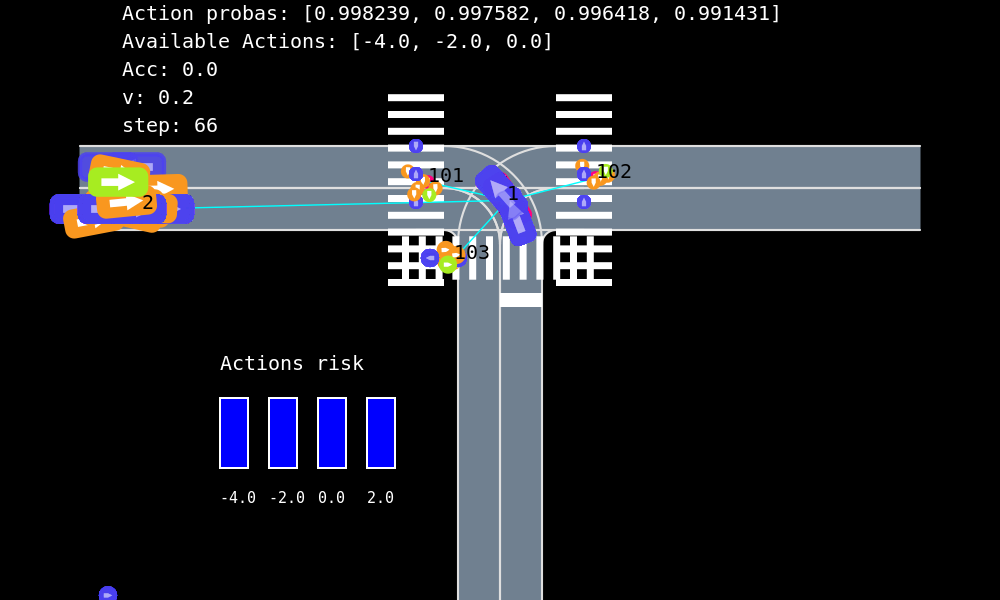
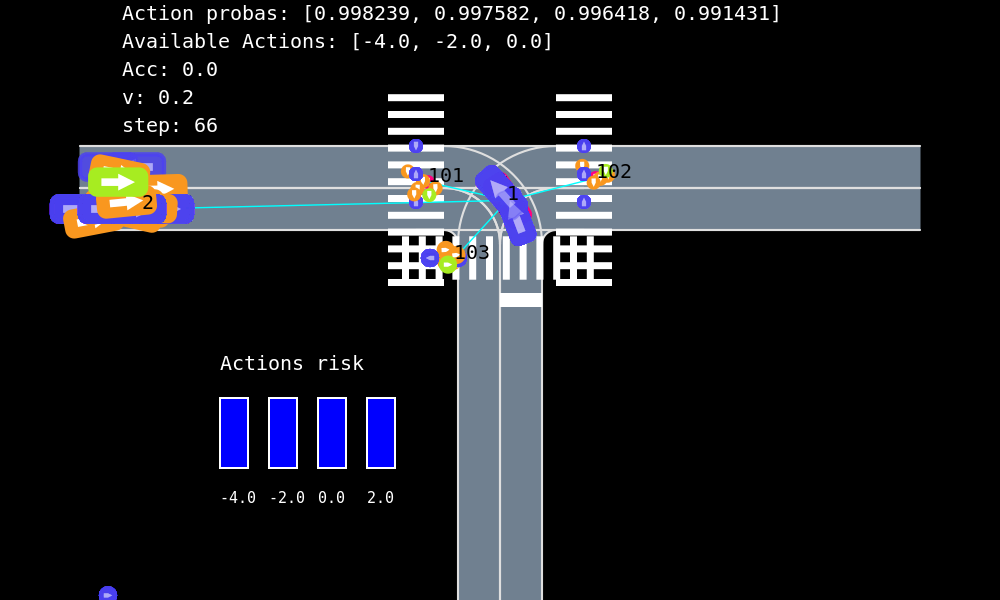

In [19]:
using Interact
@manipulate for step=2:n_steps(hist)
    s = hist.state_hist[step]
    a = hist.action_hist[step-1]
    safe_acts = hist.ainfo_hist[step-1][1]
    probas = hist.ainfo_hist[step-1][2]
    driver_models = hist.info_hist[step-1]
    o = hist.observation_hist[step-1]
    b = hist.belief_hist[step];
    overlays = SceneOverlay[]
    occlusion_overlay = OcclusionOverlay(obstacles=pomdp.env.obstacles)
    push!(overlays, occlusion_overlay)
    obs = [veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID]
    obs_overlay = GaussianSensorOverlay(o=obs, color=MONOKAI["color2"])
    for (b_id, b_indiv) in b
        for pred in b_indiv.predictions
            bb, car_pres, ped_pres = process_prediction(rnn_pomdp, pred, b_indiv.obs)
            bel = [veh for veh in obs_to_scene(rnn_pomdp, bb) if veh.id != EGO_ID]
            bel_overlay = GaussianSensorOverlay(o=bel, color=MONOKAI["color4"])    
            itp_overlay = InterpolationOverlay(mdp, driver_models, obs_to_scene(rnn_pomdp, bb))
            push!(overlays, itp_overlay)
            push!(overlays, bel_overlay)
        end
    end
    for (i,prob) in enumerate(probas)
        color = (prob < threshold && i != actionindex(pomdp, a)) ? RGB(1.0,0.0,0.0) : RGB(0.0,0.0,1.0)
        push!(overlays, HistogramOverlay(pos=VecE2(-20. + 3.5*(i-1), -20.), val=prob, label="$(actions(pomdp)[i].acc)", fill_color=color))
    end
    push!(overlays, obs_overlay)
    push!(overlays, TextOverlay(text = ["Actions risk"], pos=VecE2(-20.0,-13.0), 
                                font_size=20, incameraframe=true))
    push!(overlays, TextOverlay(text = ["v: $(round(get_ego(s).state.v, digits=2))"], font_size=20, 
                                    pos=VecE2(pomdp.env.params.x_min + 3.,6.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["Acc: $(a.acc)"], font_size=20,
                                    pos=VecE2(pomdp.env.params.x_min + 3.,8.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["Available Actions: $([a.acc for a in safe_acts])"], font_size=20,
                                    pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["Action probas: $probas"],
                                font_size=20,
                                pos=VecE2(pomdp.env.params.x_min + 3.,12),
                                incameraframe=true))
    push!(overlays, TextOverlay(text = ["step: $step"], font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true))
    push!(overlays, IDOverlay())
    AutoViz.render(s, pomdp.env, overlays, cam = StaticCamera(VecE2(0., -8.), 14.0))
end

In [21]:
function render_hist(t, dt)
    step = Int(floor(t/dt)) + 2
    s = hist.state_hist[step]
    a = hist.action_hist[step-1]
    safe_acts = hist.ainfo_hist[step-1][1]
    o = hist.observation_hist[step-1]
    b = hist.belief_hist[step];
    overlays = SceneOverlay[]
    occlusion_overlay = OcclusionOverlay(obstacles=pomdp.env.obstacles)
    push!(overlays, occlusion_overlay)
    obs = [veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID]
    obs_overlay = GaussianSensorOverlay(o=obs, color=MONOKAI["color2"])
    for (b_id, b_indiv) in b
        for pred in b_indiv.predictions
            bb, car_pres, ped_pres = process_prediction(rnn_pomdp, pred, b_indiv.obs)
            bel = [veh for veh in obs_to_scene(rnn_pomdp, bb) if veh.id != EGO_ID]
            bel_overlay = GaussianSensorOverlay(o=bel, color=MONOKAI["color4"])            
            push!(overlays, bel_overlay)
        end
    end
    push!(overlays, obs_overlay)
    push!(overlays, TextOverlay(text = ["v: $(get_ego(s).state.v)"], font_size=20, 
                                    pos=VecE2(pomdp.env.params.x_min + 3.,6.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["Acc: $(a.acc)"], font_size=20,
                                    pos=VecE2(pomdp.env.params.x_min + 3.,8.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["Available Actions: $([a.acc for a in safe_acts])"], font_size=20,
                                    pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true))
    push!(overlays, TextOverlay(text = ["step: $step"], font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true))
    push!(overlays, IDOverlay())
    AutoViz.render(s, pomdp.env, overlays, cam = StaticCamera(VecE2(0., -8.), 14.0))
end
                                
sim_dt = 0.1
duration = (length(hist.state_hist) -1)*sim_dt
fps = Int(1/sim_dt)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpOdl83C", 0x0000000000000083, 10.0, nothing)

In [48]:
function evaluation_loop(pomdp::UrbanPOMDP, policy::Policy, up::DecUpdater; n_ep::Int64 = 1000, max_steps::Int64 = 500, rng::AbstractRNG = Base.GLOBAL_RNG)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    violations = zeros(n_ep)
    empty_b = Dict{NTuple{3, Int64}, PedCarRNNBelief}()
    @showprogress for ep=1:n_ep
#         @printf("Starting episode: %i", ep)
        s0 = initialstate(pomdp, rng)
        a0 = UrbanAction(0.0)
        o0 = generate_o(pomdp, s0, a0, s0, rng)
        b0 = update(up, empty_b, a0, o0)
        hr = HistoryRecorder(rng=rng, max_steps=max_steps)
#         println("Initialization done.")
        hist = simulate(hr, pomdp, policy, up, b0, s0);
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
        violations[ep] = is_crash(hist.state_hist[end])#sum(hist.reward_hist .<= -1.) #+ Int(n_steps(hist) >= max_steps)
    end
    return rewards, steps, violations
end

evaluation_loop (generic function with 4 methods)

In [49]:
include("decomposition.jl")

In [50]:
up = DecUpdater(pomdp, Dict((0,0,0) => PedCarRNNUpdater(models, mdp, rnn_pomdp)))
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, dec_pol, up, n_ep=100, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:29

2928.633302 seconds (7.54 G allocations: 603.570 GiB, 32.55% gc time)
Summary for 100 episodes: 
Average reward: 0.006 
Average # of steps: 205.170 
Average # of violations: 0.000 


Progress: 100%|█████████████████████████████████████████| Time: 0:48:48


In [67]:
include("decomposition.jl")

In [69]:
action_info(dec_pol, b)

(UrbanAction(0.0), UrbanAction[UrbanAction(-4.0), UrbanAction(-2.0), UrbanAction(0.0)])

In [63]:
function MDPModelChecking.safe_actions(pomdp::UrbanPOMDP, mask::SafetyMask{PedCarMDP, P}, b::Dict{I, PedCarRNNBelief}) where {P <: Policy,I}
    reduce(intersect, safe_actions(pomdp, mask, bel) for (_, bel) in b)
end

In [35]:
?setinter

search: PreviousObservationUpdater PrimedPreviousObservationUpdater

Couldn't find setinter
Perhaps you meant setindex, setindex!, getindex, pointer or set_latex


No documentation found.

Binding `setinter` does not exist.


In [46]:
reduce(intersect, safe_actions(pomdp, mask, bel) for (_, bel) in b)

3-element Array{UrbanAction,1}:
 UrbanAction(-4.0)
 UrbanAction(-2.0)
 UrbanAction(0.0) 

In [39]:
union(rand(2), rand(2))

4-element Array{Float64,1}:
 0.8199879182336396 
 0.12935395369208624
 0.5221660034238984 
 0.7914074427340936 

## Prototype decomposition method

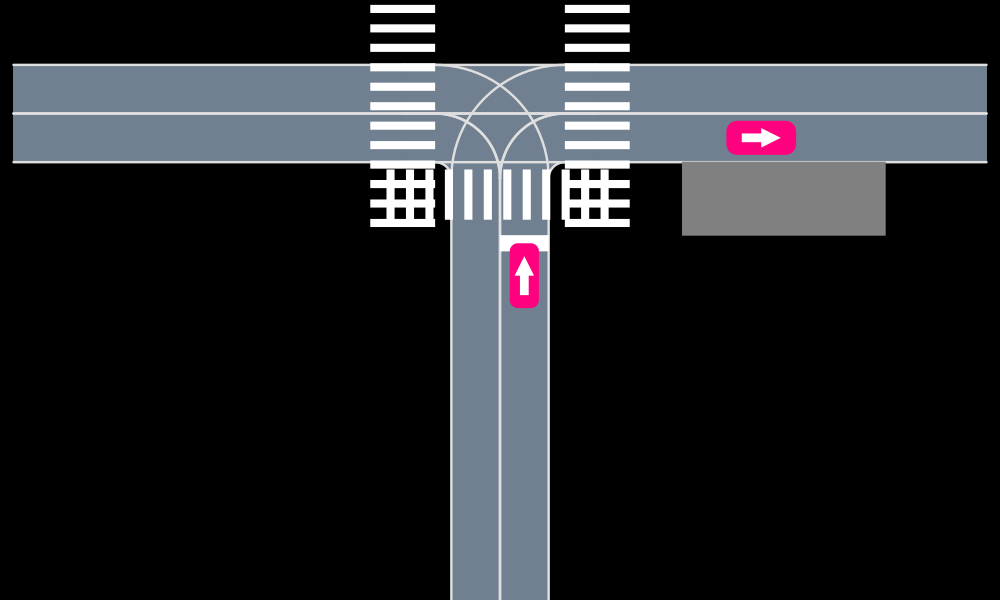

In [11]:
s0 = initialstate(pomdp, rng)
a0 = UrbanAction(0.0)
o0 = generate_o(pomdp, s0, a0, s0, rng);
AutoViz.render(s0, pomdp.env, cam=cam)

In [186]:
up = PedCarRNNUpdater(models, mdp, rnn_pomdp)
reset_updater!(up)

In [187]:
using DataStructures

**Step 1: split the observation between ego, car, ped and obstacle parts**

In [188]:
function AutomotivePOMDPs.split_o(obs::UrbanObs, pomdp::UrbanPOMDP)
    car_map, ped_map, obs_map = OrderedDict{Int64, Vector{Float64}}(), OrderedDict{Int64, Vector{Float64}}(), OrderedDict{Int64, Vector{Float64}}() #XXX Dictionary creation is sloooooow
    n_features = pomdp.n_features
    ego = obs[1:n_features]
    absent = normalized_off_the_grid_pos(pomdp, ego[1], ego[2])
#     println("ego idx ", 1, ":", n_features)
    for (j,i) in enumerate(1:pomdp.max_cars)
        if obs[i*n_features+1:(i+1)*n_features] != absent
            car_map[j] = obs[i*n_features+1:(i+1)*n_features]
        end
#         println("car$j idx ", i*n_features+1:(i+1)*n_features)
    end
    for (j,i) in enumerate(pomdp.max_cars + 1:pomdp.max_cars + pomdp.max_peds)
        if obs[i*n_features+1:(i+1)*n_features] != absent
            ped_map[j] = obs[i*n_features+1:(i+1)*n_features]
        end
#         println("ped$j idx ", i*n_features+1:(i+1)*n_features)
    end
    for (j,i)  in enumerate(pomdp.max_cars + pomdp.max_peds + 1:pomdp.max_cars + pomdp.max_peds + pomdp.max_obstacles)
        obs_map[j] = obs[i*n_features+1:(i+1)*n_features]
#         println("obs$j idx ", i*n_features+1:(i+1)*n_features)
    end
    return ego, car_map, ped_map, obs_map
end

In [189]:
ego, car_map, ped_map, obs_map = split_o(o0, pomdp)

([0.0625, -0.416667, 1.0, 0.0], OrderedDict{Int64,Array{Float64,1}}(), OrderedDict(1=>[-0.264835, 0.370014, 0.5, 0.0988673]), OrderedDict(1=>[1.04167, 0.1875, 0.666667, 0.197917]))

**Step 2: Augment o with an absent car and an absent pedestrian**

In [190]:
function augment_with_absent_state!(pomdp::UrbanPOMDP, dict::OrderedDict{Int64, Vector{Float64}}, ego::Vector{Float64})
    id = length(keys(dict))
    ego_x, ego_y, theta, v = ego
    pos_off =  get_off_the_grid(pomdp)
    max_ego_dist = get_end(pomdp.env.roadway[pomdp.ego_goal])
    dict[id + 1] = [pos_off.posG.x/max_ego_dist - ego_x,
                    pos_off.posG.y/max_ego_dist - ego_y,
                    pos_off.posG.θ/float(pi),
                    0. ]
    return dict 
end

augment_with_absent_state! (generic function with 1 method)

In [191]:
augment_with_absent_state!(pomdp, car_map, ego)
augment_with_absent_state!(pomdp, ped_map, ego)

OrderedDict{Int64,Array{Float64,1}} with 2 entries:
  1 => [-0.264835, 0.370014, 0.5, 0.0988673]
  2 => [-1.22917, -0.795833, 0.0, 0.0]

**Step 3: create independent observation corresponding to the subtasks**

Subtask: ego, car, ped, obs for every car ped and obstacles

In [192]:
function create_pedcar_states(ego, car_map, ped_map, obs_map)
    decomposed_state = Dict{NTuple{3, Int64}, Vector{Float64}}()
    for (car_id, car) in car_map
        for (ped_id, ped) in ped_map
            for (obs_id, obs) in obs_map
                decomposed_state[(car_id, ped_id, obs_id)] = vcat(ego, car, ped, obs)
            end
        end
    end
    return decomposed_state
end

create_pedcar_states (generic function with 1 method)

In [193]:
dec_o0 = create_pedcar_states(ego, car_map, ped_map, obs_map)

Dict{Tuple{Int64,Int64,Int64},Array{Float64,1}} with 2 entries:
  (1, 1, 1) => [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, -0.…
  (1, 2, 1) => [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, -1.…

**Step 4: belief update**

The belief is represented by a dictionary mapping (car_id, ped_id, obs_id) to the associated prediction. 

The updater is getting the old belief and the decomposed observation. 

```
For all keys in observation:
    If it is in old_belief, update the corresponding belief
    If it is not, update an absent belief 
```    



In [194]:
dec_updater = DecUpdater(pomdp, Dict((0,0,0) => PedCarRNNUpdater(models, mdp, rnn_pomdp)))
init_dec_belief = Dict{NTuple{3, Int64}, PedCarRNNBelief}()

Dict{Tuple{Int64,Int64,Int64},PedCarRNNBelief} with 0 entries

In [195]:
struct DecUpdater{P <: POMDP, I, U<:Updater} <: Updater
    problem::P
    updaters::Dict{I, U}
end

In [196]:
function POMDPs.update(up::DecUpdater, bold::Dict{NTuple{3, Int64}, PedCarRNNBelief}, a::UrbanAction, o::UrbanObs)
    ego, car_map, ped_map, obs_map = split_o(o, up.problem)
    augment_with_absent_state!(up.problem, car_map, ego)
    augment_with_absent_state!(up.problem, ped_map, ego)
    dec_o = create_pedcar_states(ego, car_map, ped_map, obs_map)
    ref_up = up.updaters[(0,0,0)]
    bnew = Dict{NTuple{3, Int64}, PedCarRNNBelief}()
    for (obs_id, obs) in dec_o
        if haskey(bold, obs_id) 
            @assert haskey(up.updaters, obs_id) # should have an associated filter 
            bnew[obs_id] = update(up.updaters[obs_id], bold[obs_id], a, obs)
        else # instantiate new filter 
            up.updaters[obs_id] = PedCarRNNUpdater(deepcopy(ref_up.models), ref_up.mdp, ref_up.pomdp) # could do something smarter than deepcopy
            reset_updater!(up.updaters[obs_id])
            init_belief = PedCarRNNBelief(Vector{Vector{Float64}}(undef, n_models), obs)
            bnew[obs_id] = update(up.updaters[obs_id], init_belief, a, obs)
        end
    end
    return bnew
end            

In [197]:
update(dec_updater, init_dec_belief, a0, o0)

Dict{Tuple{Int64,Int64,Int64},PedCarRNNBelief} with 2 entries:
  (1, 1, 1) => PedCarRNNBelief(Array{Float64,1}[[0.64618, 0.37476, 0.681484, 0.…
  (1, 2, 1) => PedCarRNNBelief(Array{Float64,1}[[0.685844, 0.373603, 0.668659, …

**Decomposition of the policy with utility fusion**

In [19]:
function fuse_values(policy::P, dec_belief::Dict, op) where P <: Policy # no hidden state!
    reduce(op, value(policy, b) for (k,b) in dec_belief)
end

fuse_values (generic function with 1 method)

## Simulation

## Visualization

In [164]:
 b = hist.belief_hist[25]

Dict{Tuple{Int64,Int64,Int64},PedCarRNNBelief} with 3 entries:
  (3, 1, 1) => PedCarRNNBelief(Array{Float64,1}[[-1.15332, 0.343506, 0.0494445,…
  (2, 1, 1) => PedCarRNNBelief(Array{Float64,1}[[-1.12729, 0.310331, -0.0544222…
  (1, 1, 1) => PedCarRNNBelief(Array{Float64,1}[[0.431569, 0.478287, 0.98694, 0…

In [142]:
using Pkg
Pkg.add("Interact")

 Resolving package versions...
  Updating `/mnt/c/Users/Maxime/wsl/.julia/environments/v1.0/Project.toml`
  [c601a237] + Interact v0.9.0
  Updating `/mnt/c/Users/Maxime/wsl/.julia/environments/v1.0/Manifest.toml`
  [bf4720bc] + AssetRegistry v0.1.0
  [70588ee8] + CSSUtil v0.1.0
  [de31a74c] + FunctionalCollections v0.4.0
  [c601a237] + Interact v0.9.0
  [d3863d7c] + InteractBase v0.8.1
  [7981ab7d] + InteractBulma v0.4.2
  [97c1335a] + JSExpr v0.3.1
  [bcebb21b] + Knockout v0.2.0
  [510215fc] + Observables v0.2.2
  [fa939f87] + Pidfile v1.1.0
  [0f1e0344] + WebIO v0.4.0
  [cc8bc4a8] + Widgets v0.4.2
